# Setup & Installation

In [1]:
# Install packages
!pip install --quiet py7zr xgboost tensorflow catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 1.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 7.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 428.8/428.8 kB 15.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.29.5 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.

In [2]:
# Import libraries
import os
from pathlib import Path

import numpy as np
import pandas as pd
import py7zr
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from IPython.display import display
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import friedmanchisquare, rankdata, t
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import tensorflow as tf

warnings.filterwarnings('ignore', category=FutureWarning)
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 5)
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda v: f'{v:,.3f}')
np.random.seed(42)
PYTHONHASHSEED = 42


2025-11-21 17:09:50.695224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763744991.024006      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763744991.118254      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Configuration
DATA_CANDIDATES = [
    Path('/kaggle/input/corporacion-favorita-grocery-sales-forecasting'),
    Path('/kaggle/input/favorita-grocery-sales-forecasting'),
    Path('../input/favorita-grocery-sales-forecasting'),
    Path('./data'),
]

WINDOW_END = pd.Timestamp('2017-08-15')
WINDOW_START = WINDOW_END - pd.Timedelta(days=364)
DATE_INDEX = pd.date_range(WINDOW_START, WINDOW_END, freq='D', name='date')
REPORT_START = pd.Timestamp('2023-01-01')
REPORT_INDEX = pd.date_range(REPORT_START, periods=len(DATE_INDEX), freq='D', name='report_date')
DATE_TO_REPORT = pd.Series(REPORT_INDEX.values, index=DATE_INDEX)
TOTAL_DAYS = len(DATE_INDEX)
HOLDOUT_DAYS = 60
LOOKBACK = 30

OUTPUT_DIR = Path('./processed_output')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('Outputs will be written to:', OUTPUT_DIR.resolve())

Outputs will be written to: /kaggle/working/processed_output


# Data Loading & Preprocessing Functions

In [4]:
# Helper functions
CHUNKSIZE = 2_000_000

def detect_data_root(candidates):
    for candidate in candidates:
        if candidate.exists():
            if (candidate / 'train.csv').exists() or (candidate / 'train.csv.7z').exists():
                return candidate
    raise FileNotFoundError('Favorita dataset not found.')

def ensure_unzipped(root: Path) -> Path:
    if list(root.glob('*.csv')):
        return root
    archives = list(root.glob('*.csv.7z'))
    if not archives:
        return root
    target = Path('./favorita_unzipped')
    target.mkdir(parents=True, exist_ok=True)
    for archive in archives:
        out_path = target / archive.name.replace('.7z', '')
        if out_path.exists():
            continue
        with py7zr.SevenZipFile(archive, mode='r') as zf:
            zf.extractall(path=target)
    return target

def _convert_onpromotion(value):
    if pd.isna(value):
        return 0
    if isinstance(value, str):
        stripped = value.strip().lower()
        if stripped in {'true', 't', '1', 'yes', 'y'}:
            return 1
        if stripped in {'false', 'f', '0', 'no', 'n'}:
            return 0
        try:
            return int(float(stripped))
        except ValueError:
            return 0
    try:
        return int(float(value))
    except (TypeError, ValueError):
        return 0

def load_window(root: Path) -> pd.DataFrame:
    cols = ['date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion']
    dtype = {'store_nbr': 'int16', 'item_nbr': 'int32', 'unit_sales': 'float32'}
    reader = pd.read_csv(
        root / 'train.csv',
        usecols=cols,
        dtype=dtype,
        parse_dates=['date'],
        chunksize=CHUNKSIZE,
        low_memory=False,
    )
    fragments = []
    for chunk in reader:
        mask = (chunk['date'] >= WINDOW_START) & (chunk['date'] <= WINDOW_END)
        if not mask.any():
            continue
        filtered = chunk.loc[mask].copy()
        filtered['unit_sales'] = filtered['unit_sales'].clip(lower=0)
        filtered['onpromotion'] = filtered['onpromotion'].apply(_convert_onpromotion).astype('int8')
        fragments.append(filtered)
    if not fragments:
        raise ValueError('No records found inside the requested 365-day window.')
    return pd.concat(fragments, ignore_index=True)

def select_items(df: pd.DataFrame, top_n: int = 20) -> list[int]:
    stats = df.groupby('item_nbr').agg(
        observed_days=('date', 'nunique'),
        total_sales=('unit_sales', 'sum'),
    )
    stats['zero_share_full'] = 1 - stats['observed_days'] / TOTAL_DAYS
    candidates = stats[(stats['observed_days'].between(20, 80)) & (stats['total_sales'] > 10)]
    selected = candidates.sort_values('zero_share_full', ascending=False).head(top_n)
    if len(selected) < top_n:
        selected = stats.sort_values('zero_share_full', ascending=False).head(top_n)
    return selected.index.astype(int).tolist()

def prepare_transactions(root: Path, stores: np.ndarray) -> pd.DataFrame:
    trans = pd.read_csv(root / 'transactions.csv', parse_dates=['date'])
    trans = trans[trans['store_nbr'].isin(stores)]
    trans = trans[(trans['date'] >= WINDOW_START) & (trans['date'] <= WINDOW_END)].copy()
    index = pd.MultiIndex.from_product([stores, DATE_INDEX], names=['store_nbr', 'date'])
    trans = trans.set_index(['store_nbr', 'date']).reindex(index)
    trans['transactions'] = trans.groupby(level=0)['transactions'].ffill().fillna(0).astype('float32')
    return trans.reset_index()

def prepare_oil(root: Path) -> pd.DataFrame:
    oil = pd.read_csv(root / 'oil.csv', parse_dates=['date'])
    oil = oil[oil['date'] >= WINDOW_START - pd.Timedelta(days=30)].copy()
    oil['dcoilwtico'] = oil['dcoilwtico'].ffill()
    oil = oil.rename(columns={'dcoilwtico': 'oil_price'})
    oil['oil_price'] = oil['oil_price'].astype('float32')
    return oil

def prepare_holidays(root: Path) -> pd.DataFrame:
    holidays = pd.read_csv(root / 'holidays_events.csv', parse_dates=['date'])
    holidays = holidays[(holidays['date'] >= WINDOW_START) & (holidays['date'] <= WINDOW_END)].copy()
    holidays['is_holiday'] = holidays['type'].isin({'Holiday', 'Transfer', 'Bridge'}).astype('int8')
    holidays['is_event'] = holidays['type'].isin({'Event', 'Work Day'}).astype('int8')
    agg = holidays.groupby('date').agg(
        holiday_count=('type', 'count'),
        any_holiday=('is_holiday', 'max'),
        any_event=('is_event', 'max'),
        national_holiday=('locale', lambda x: int('National' in set(x))),
        regional_holiday=('locale', lambda x: int('Regional' in set(x))),
        local_holiday=('locale', lambda x: int('Local' in set(x))),
    ).reset_index()
    descriptions = holidays.groupby('date')['description'].agg(lambda vals: '; '.join(sorted(set(vals)))).reset_index()
    merged = agg.merge(descriptions, on='date', how='left').rename(columns={'description': 'holiday_descriptions'})
    merged['holiday_descriptions'] = merged['holiday_descriptions'].fillna('')
    merged['holiday_count'] = merged['holiday_count'].astype('int16')
    for col in ['any_holiday', 'any_event', 'national_holiday', 'regional_holiday', 'local_holiday']:
        merged[col] = merged[col].astype('int8')
    return merged

def add_calendar_features(df: pd.DataFrame) -> pd.DataFrame:
    df['day_of_week'] = df['report_date'].dt.dayofweek.astype('int8')
    df['week_of_year'] = df['report_date'].dt.isocalendar().week.astype('int16')
    df['month'] = df['report_date'].dt.month.astype('int8')
    df['quarter'] = df['report_date'].dt.quarter.astype('int8')
    df['is_weekend'] = df['day_of_week'].isin({5, 6}).astype('int8')
    return df

def add_lag_features(df: pd.DataFrame) -> pd.DataFrame:
    for lag in [1, 2, 7, 14, 30]:
        df[f'lag_{lag}'] = df.groupby('item_nbr')['unit_sales'].shift(lag).astype('float32')
    for window in [7, 14, 30]:
        df[f'roll_mean_{window}'] = df.groupby('item_nbr')['unit_sales'].transform(lambda s: s.rolling(window).mean()).astype('float32')
        df[f'roll_max_{window}'] = df.groupby('item_nbr')['unit_sales'].transform(lambda s: s.rolling(window).max()).astype('float32')
    for window in [7, 30]:
        df[f'promo_share_{window}'] = df.groupby('item_nbr')['onpromo_any'].transform(lambda s: s.rolling(window).mean()).astype('float32')
    return df

def add_days_since_sale(df: pd.DataFrame) -> pd.DataFrame:
    def _compute(series: pd.Series) -> np.ndarray:
        gap = -1
        output = []
        for value in series:
            if value > 0:
                gap = 0
            else:
                gap = gap + 1 if gap >= 0 else 1
            output.append(gap)
        return np.array(output, dtype='int16')
    df['days_since_sale'] = df.groupby('item_nbr')['unit_sales'].transform(_compute)
    return df

def compute_item_metadata(panel: pd.DataFrame, items_meta: pd.DataFrame) -> pd.DataFrame:
    grouped = panel.groupby('item_nbr')['unit_sales']
    stats = grouped.agg(
        total_sales='sum',
        mean_sales='mean',
        std_sales='std',
        nonzero_days=lambda s: int((s > 0).sum()),
        zero_days=lambda s: int((s == 0).sum()),
    )
    stats['adi'] = (TOTAL_DAYS / stats['nonzero_days'].replace(0, np.nan)).replace({np.inf: np.nan})
    
    def _cv2(series: pd.Series) -> float:
        nz = series[series > 0]
        if nz.empty or np.isclose(nz.mean(), 0):
            return np.nan
        return float((nz.std(ddof=0) / nz.mean()) ** 2)
    
    stats['cv2'] = grouped.apply(_cv2)
    stats['zero_share'] = stats['zero_days'] / TOTAL_DAYS
    metadata = stats.reset_index().merge(items_meta, on='item_nbr', how='left')
    for col in ['total_sales', 'mean_sales', 'std_sales', 'adi', 'cv2', 'zero_share']:
        metadata[col] = metadata[col].astype('float32')
    return metadata


# Data Loading & Feature Engineering

In [5]:
data_root = detect_data_root(DATA_CANDIDATES)
data_root = ensure_unzipped(data_root)
print('Using data root:', data_root)

raw_window = load_window(data_root)
print('Filtered window shape:', raw_window.shape)
print('Date span:', raw_window['date'].min().date(), 'to', raw_window['date'].max().date())

selected_items = select_items(raw_window)
print('Selected items:', selected_items)

focused = raw_window[raw_window['item_nbr'].isin(selected_items)].copy()

transactions = prepare_transactions(data_root, np.sort(focused['store_nbr'].unique()))
oil = prepare_oil(data_root)
holidays = prepare_holidays(data_root)
items_meta = pd.read_csv(data_root / 'items.csv')

merged = focused.merge(transactions, on=['store_nbr', 'date'], how='left', validate='many_to_one')
merged['transactions'] = merged['transactions'].fillna(0).astype('float32')

panel = (
    merged.groupby(['item_nbr', 'date']).agg(
        unit_sales=('unit_sales', 'sum'),
        stores_active=('store_nbr', 'nunique'),
        promo_store_count=('onpromotion', 'sum'),
        onpromo_any=('onpromotion', 'max'),
        transactions=('transactions', 'sum'),
    ).reset_index()
)

full_index = pd.MultiIndex.from_product([selected_items, DATE_INDEX], names=['item_nbr', 'date'])
panel = panel.set_index(['item_nbr', 'date']).reindex(full_index, fill_value=0).reset_index()
panel = panel.merge(oil, on='date', how='left')
panel['oil_price'] = panel['oil_price'].ffill().astype('float32')
panel = panel.merge(holidays, on='date', how='left')
panel['holiday_count'] = panel['holiday_count'].fillna(0).astype('int16')
for col in ['any_holiday', 'any_event', 'national_holiday', 'regional_holiday', 'local_holiday']:
    panel[col] = panel[col].fillna(0).astype('int8')
panel['holiday_descriptions'] = panel['holiday_descriptions'].fillna('')
panel['report_date'] = panel['date'].map(DATE_TO_REPORT)

mean_by_item = panel.groupby('item_nbr')['unit_sales'].transform('mean')
panel['flash_sale_flag'] = ((panel['onpromo_any'] > 0) | (panel['unit_sales'] >= np.maximum(mean_by_item, 1.0) * 3)).astype('int8')

panel = add_calendar_features(panel)
panel = add_lag_features(panel)
panel = add_days_since_sale(panel)

panel['unit_sales'] = panel['unit_sales'].astype('float32')
panel['stores_active'] = panel['stores_active'].astype('int16')
panel['promo_store_count'] = panel['promo_store_count'].astype('int16')
panel['onpromo_any'] = panel['onpromo_any'].astype('int8')
panel['transactions'] = panel['transactions'].astype('float32')

metadata = compute_item_metadata(panel, items_meta)

panel.sort_values(['item_nbr', 'date']).to_csv(OUTPUT_DIR / 'item_daily_panel.csv', index=False)
metadata.sort_values('item_nbr').to_csv(OUTPUT_DIR / 'item_metadata.csv', index=False)

print('Panel rows:', panel.shape[0])
print('Zero-demand share:', (panel['unit_sales'] == 0).mean())
print('Mean ADI:', metadata['adi'].mean())

display(panel.head())
display(metadata.head())


Using data root: favorita_unzipped
Filtered window shape: (37358381, 5)
Date span: 2016-08-16 to 2017-08-15
Selected items: [2122188, 2118662, 2127114, 2124052, 2037148, 2008567, 2113343, 2054300, 2114812, 2116416, 1352758, 2114566, 2109909, 2113914, 1239986, 1948220, 2110456, 1950263, 2111684, 1036317]
Panel rows: 7300
Zero-demand share: 0.8873972602739726
Mean ADI: 9.545824


,item_nbr,date,unit_sales,stores_active,promo_store_count,onpromo_any,transactions,oil_price,holiday_count,any_holiday,any_event,national_holiday,regional_holiday,local_holiday,holiday_descriptions,report_date,flash_sale_flag,day_of_week,week_of_year,month,quarter,is_weekend,lag_1,lag_2,lag_7,lag_14,lag_30,roll_mean_7,roll_max_7,roll_mean_14,roll_max_14,roll_mean_30,roll_max_30,promo_share_7,promo_share_30,days_since_sale
0,2122188,2016-08-16,0.000,0,0,0,0.000,46.570,0,0,0,0,0,0,,2023-01-01,0,6,52,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,2122188,2016-08-17,0.000,0,0,0,0.000,46.810,0,0,0,0,0,0,,2023-01-02,0,0,1,1,1,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,2122188,2016-08-18,0.000,0,0,0,0.000,48.200,0,0,0,0,0,0,,2023-01-03,0,1,1,1,1,0,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,2122188,2016-08-19,0.000,0,0,0,0.000,48.480,0,0,0,0,0,0,,2023-01-04,0,2,1,1,1,0,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,2122188,2016-08-20,0.000,0,0,0,0.000,48.480,0,0,0,0,0,0,,2023-01-05,0,3,1,1,1,0,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


,item_nbr,total_sales,mean_sales,std_sales,nonzero_days,zero_days,adi,cv2,zero_share,family,class,perishable
0,1036317,"5,956.000",16.318,80.112,59,306,6.186,3.047,0.838,CLEANING,3018,0
1,1239986,"134,783.094",369.269,"1,012.838",49,316,7.449,0.141,0.866,POULTRY,2420,1
2,1352758,"1,153.000",3.159,12.721,40,325,9.125,0.882,0.890,CLEANING,3004,0
3,1948220,"7,068.000",19.364,90.361,54,311,6.759,2.361,0.852,HOME AND KITCHEN II,6350,0
4,1950263,"7,299.000",19.997,96.259,55,310,6.636,2.633,0.849,GROCERY I,1030,0


# Exploratory Analysis

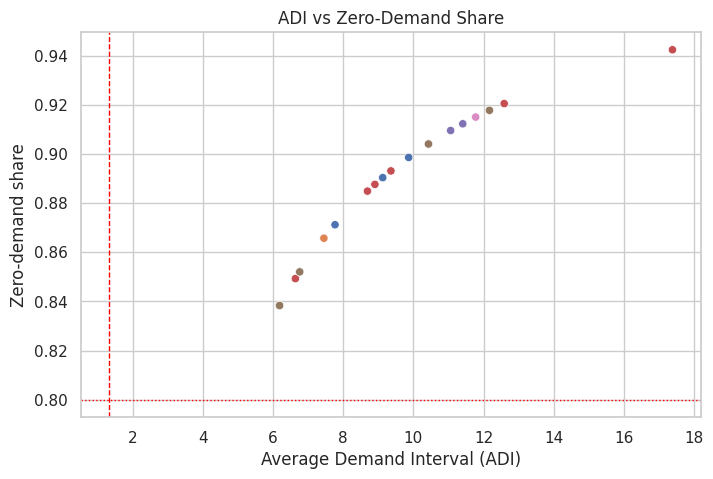

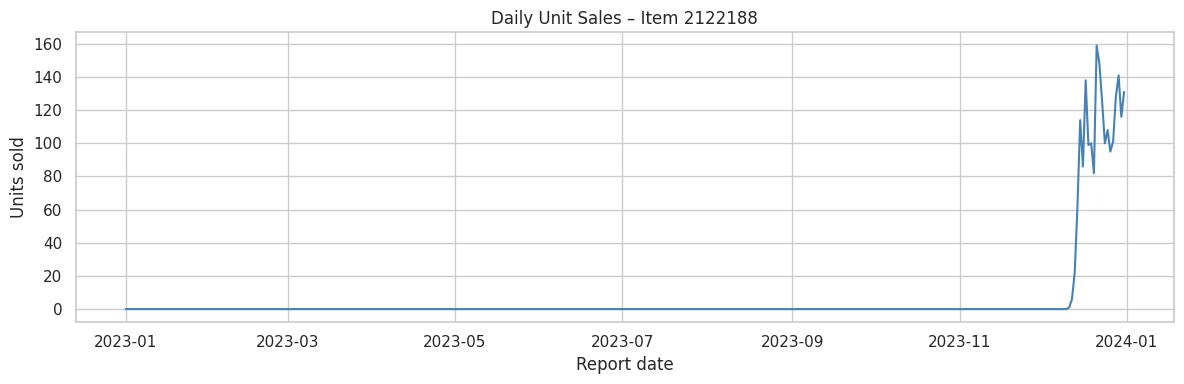

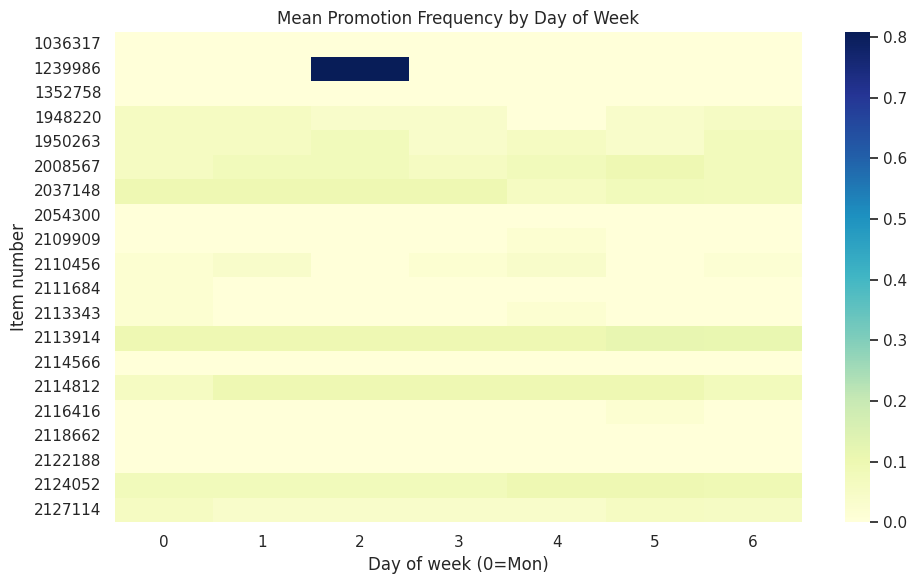

In [6]:
# Intermittency diagnostics
plt.figure(figsize=(8, 5))
sns.scatterplot(data=metadata, x='adi', y='zero_share', hue='family', legend=False)
plt.axvline(1.32, color='red', linestyle='--', linewidth=1)
plt.axhline(0.80, color='red', linestyle=':', linewidth=1)
plt.title('ADI vs Zero-Demand Share')
plt.xlabel('Average Demand Interval (ADI)')
plt.ylabel('Zero-demand share')
plt.show()

# Sample item series
target_item = metadata.sort_values('zero_share', ascending=False).iloc[0]['item_nbr']
series = panel[panel['item_nbr'] == target_item]
plt.figure(figsize=(12, 4))
plt.plot(series['report_date'], series['unit_sales'], color='steelblue')
plt.title(f'Daily Unit Sales – Item {target_item}')
plt.xlabel('Report date')
plt.ylabel('Units sold')
plt.tight_layout()
plt.show()

# Promotion heatmap
promo_table = panel.groupby(['item_nbr', 'day_of_week'])['onpromo_any'].mean().unstack(fill_value=0)
plt.figure(figsize=(10, 6))
sns.heatmap(promo_table, cmap='YlGnBu')
plt.title('Mean Promotion Frequency by Day of Week')
plt.xlabel('Day of week (0=Mon)')
plt.ylabel('Item number')
plt.tight_layout()
plt.show()


# Evaluation Metrics

In [7]:
# Define metrics functions
def mase(actual, predicted, training_data):
    """Mean Absolute Scaled Error"""
    n = len(training_data)
    if n < 2:
        return np.nan
    naive_mae = np.mean(np.abs(np.diff(training_data)))
    if np.isclose(naive_mae, 0):
        return np.nan
    forecast_errors = np.abs(actual - predicted)
    return float(np.mean(forecast_errors) / naive_mae)

def wmape(actual, predicted):
    """Weighted Mean Absolute Percentage Error"""
    denom = np.sum(np.abs(actual))
    if np.isclose(denom, 0):
        return np.nan
    return float(np.sum(np.abs(actual - predicted)) / denom)

def spike_precision_recall(actual, predicted, threshold):
    """Spike detection precision and recall"""
    actual_spikes = actual > threshold
    predicted_spikes = predicted > threshold
    tp = np.sum(actual_spikes & predicted_spikes)
    fp = np.sum(~actual_spikes & predicted_spikes)
    fn = np.sum(actual_spikes & ~predicted_spikes)
    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    return precision, recall


# MODEL TRAINING

### 6.1: Baseline Models

In [8]:
def train_valid_split(df: pd.DataFrame, holdout: int = HOLDOUT_DAYS) -> tuple[pd.Series, pd.Series]:
    if len(df) <= holdout:
        raise ValueError('Holdout window larger than series length.')
    y = df['unit_sales'].astype(float)
    return y.iloc[:-holdout], y.iloc[-holdout:]


def mase(y_true: np.ndarray, y_pred: np.ndarray, insample: np.ndarray) -> float:
    insample = np.asarray(insample)
    if len(insample) <= 1:
        return np.nan
    denom = np.mean(np.abs(insample[1:] - insample[:-1]))
    if denom == 0:
        return np.nan
    return np.mean(np.abs(y_true - y_pred)) / denom


def wmape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    denom = np.sum(np.abs(y_true))
    if denom == 0:
        return np.nan
    return np.sum(np.abs(y_true - y_pred)) / denom


def spike_precision_recall(y_true: np.ndarray, y_pred: np.ndarray, threshold: float) -> tuple[float, float]:
    actual_spikes = y_true >= threshold
    predicted_spikes = y_pred >= threshold
    tp = np.sum(actual_spikes & predicted_spikes)
    predicted = np.sum(predicted_spikes)
    actual = np.sum(actual_spikes)
    precision = tp / predicted if predicted else np.nan
    recall = tp / actual if actual else np.nan
    return precision, recall


In [9]:
def seasonal_naive(train: np.ndarray, horizon: int, seasonality: int = 7) -> np.ndarray:
    season = train[-seasonality:]
    reps = int(np.ceil(horizon / seasonality))
    return np.tile(season, reps)[:horizon]


def simple_exponential_smoothing(train: np.ndarray, horizon: int) -> np.ndarray:
    if len(train) < 2:
        return np.repeat(train[-1], horizon)
    model = ExponentialSmoothing(train, trend=None, seasonal=None, initialization_method='estimated')
    fit = model.fit(optimized=True)
    return fit.forecast(horizon)


def croston(train: np.ndarray, horizon: int, variant: str = 'croston', alpha: float = 0.1, beta: float = 0.1) -> np.ndarray:
    demand = np.array(train, dtype=float)
    demand[demand < 0] = 0
    n = len(demand)
    if n == 0:
        return np.zeros(horizon)

    z = np.zeros(n)
    q = np.ones(n)
    positive_idx = np.where(demand > 0)[0]
    if len(positive_idx) == 0:
        return np.zeros(horizon)
    first_pos = positive_idx[0]
    z[0] = demand[first_pos]
    q[0] = max(first_pos + 1, 1)

    for t in range(1, n):
        if demand[t] > 0:
            z[t] = z[t - 1] + alpha * (demand[t] - z[t - 1])
            q[t] = q[t - 1] + alpha * (1 - q[t - 1])
        else:
            z[t] = z[t - 1]
            q[t] = q[t - 1] + alpha * (0 - q[t - 1])

    forecast = z[-1] / max(q[-1], 1e-3)

    if variant.lower() == 'sba':
        forecast *= (1 - alpha / 2)
    elif variant.lower() == 'tsb':
        occurrence = (demand > 0).astype(float)
        p = np.zeros(n)
        s = np.zeros(n)
        p[0] = occurrence[0]
        s[0] = demand[positive_idx[0]]
        for t in range(1, n):
            p[t] = p[t - 1] + beta * (occurrence[t] - p[t - 1])
            if demand[t] > 0:
                s[t] = s[t - 1] + alpha * (demand[t] - s[t - 1])
            else:
                s[t] = s[t - 1]
        forecast = p[-1] * s[-1]

    return np.repeat(forecast, horizon)


In [10]:
baseline_results = []
baseline_forecasts = {model: {} for model in ['naive', 'seasonal_naive', 'ses', 'croston', 'sba', 'tsb']}
actual_holdout = {}

for item_id, item_df in panel.groupby('item_nbr', sort=False):
    y_train, y_test = train_valid_split(item_df)
    train_values = y_train.values
    test_values = y_test.values
    actual_holdout[item_id] = test_values

    forecasts = {
        'naive': np.repeat(train_values[-1], HOLDOUT_DAYS),
        'seasonal_naive': seasonal_naive(train_values, HOLDOUT_DAYS, seasonality=7),
        'ses': simple_exponential_smoothing(train_values, HOLDOUT_DAYS),
        'croston': croston(train_values, HOLDOUT_DAYS, variant='croston'),
        'sba': croston(train_values, HOLDOUT_DAYS, variant='sba'),
        'tsb': croston(train_values, HOLDOUT_DAYS, variant='tsb'),
    }

    threshold = 3 * max(1.0, train_values.mean())

    for name, forecast in forecasts.items():
        baseline_forecasts[name][item_id] = forecast
        precision, recall = spike_precision_recall(test_values, forecast, threshold)
        baseline_results.append({
            'item_nbr': item_id,
            'model': name,
            'MASE': mase(test_values, forecast, train_values),
            'wMAPE': wmape(test_values, forecast),
            'SpikePrecision': precision,
            'SpikeRecall': recall,
        })

baseline_results = pd.DataFrame(baseline_results)
baseline_results.head()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1380: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1387: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1380: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1387: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:1380: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
/usr/local/lib/python3.11/dist-packages/sta

,item_nbr,model,MASE,wMAPE,SpikePrecision,SpikeRecall
0,2122188,naive,NaN,1.000,NaN,0.000
1,2122188,seasonal_naive,NaN,1.000,NaN,0.000
2,2122188,ses,NaN,1.000,NaN,0.000
3,2122188,croston,NaN,1.000,NaN,0.000
4,2122188,sba,NaN,1.000,NaN,0.000


In [11]:
# Baseline summary
baseline_summary = baseline_results.groupby('model')[['MASE', 'wMAPE', 'SpikePrecision', 'SpikeRecall']].mean().sort_values('MASE')
display(baseline_summary)

,MASE,wMAPE,SpikePrecision,SpikeRecall
model,,,,
seasonal_naive,2.443,0.946,0.875,0.071
ses,2.527,1.073,NaN,0.000
tsb,2.549,1.105,NaN,0.000
naive,2.812,1.500,0.117,0.071
sba,"24,615.606",535.358,0.077,0.143
croston,"25,911.294",563.498,0.077,0.143


### 6.2: SARIMAX

In [12]:
sarimax_exog_cols = [
    'onpromo_any', 'promo_share_7', 'promo_share_30', 'holiday_count', 'any_holiday',
    'any_event', 'oil_price', 'transactions', 'day_of_week', 'is_weekend'
]

sarimax_results = []
sarimax_forecasts = {}

for item_id, item_df in panel.groupby('item_nbr', sort=False):
    train_df = item_df.iloc[:-HOLDOUT_DAYS].copy()
    test_df = item_df.iloc[-HOLDOUT_DAYS:].copy()

    exog_train = train_df[sarimax_exog_cols]
    exog_test = test_df[sarimax_exog_cols]

    try:
        model = SARIMAX(
            train_df['unit_sales'],
            exog=exog_train,
            order=(1, 0, 0),
            seasonal_order=(1, 1, 0, 7),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        fit = model.fit(disp=False)
        forecast = fit.forecast(steps=HOLDOUT_DAYS, exog=exog_test)
        sarimax_forecasts[item_id] = forecast.values

        precision, recall = spike_precision_recall(
            test_df['unit_sales'].values,
            forecast.values,
            threshold=3 * max(1.0, train_df['unit_sales'].mean()),
        )

        sarimax_results.append({
            'item_nbr': item_id,
            'model': 'sarimax',
            'MASE': mase(test_df['unit_sales'].values, forecast.values, train_df['unit_sales'].values),
            'wMAPE': wmape(test_df['unit_sales'].values, forecast.values),
            'SpikePrecision': precision,
            'SpikeRecall': recall,
        })
    except Exception as exc:
        sarimax_forecasts[item_id] = None
        sarimax_results.append({
            'item_nbr': item_id,
            'model': 'sarimax',
            'MASE': np.nan,
            'wMAPE': np.nan,
            'SpikePrecision': np.nan,
            'SpikeRecall': np.nan,
            'error': str(exc)
        })

sarimax_results = pd.DataFrame(sarimax_results)
display(sarimax_results.head())


,item_nbr,model,MASE,wMAPE,SpikePrecision,SpikeRecall,error
0,2122188,sarimax,NaN,NaN,NaN,NaN,exog contains inf or nans
1,2118662,sarimax,NaN,NaN,NaN,NaN,exog contains inf or nans
2,2127114,sarimax,NaN,NaN,NaN,NaN,exog contains inf or nans
3,2124052,sarimax,NaN,NaN,NaN,NaN,exog contains inf or nans
4,2037148,sarimax,NaN,NaN,NaN,NaN,exog contains inf or nans


In [13]:
# SARIMAX summary
sarimax_summary = sarimax_results.groupby('model')[['MASE', 'wMAPE', 'SpikePrecision', 'SpikeRecall']].mean()
display(sarimax_summary)

# failed = sarimax_results[sarimax_results['MASE'].isna()]
# if not failed.empty:
#     print('SARIMAX failures:')
#     display(failed[['item_nbr', 'error']])

,MASE,wMAPE,SpikePrecision,SpikeRecall
model,,,,
sarimax,NaN,NaN,NaN,NaN


### 6.3: XGBoost

In [14]:
panel_ml = panel.copy()

# Encode item_nbr for tree-based models
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
panel_ml['item_nbr_enc'] = le.fit_transform(panel_ml['item_nbr'])

# Define feature columns for XGBoost and CatBoost
feature_cols = [
    'item_nbr_enc', 
    'onpromo_any', 
    'transactions', 
    'oil_price', 
    'holiday_count',
    'any_holiday', 
    'any_event', 
    'national_holiday', 
    'regional_holiday', 
    'local_holiday',
    'day_of_week', 
    'week_of_year', 
    'month', 
    'quarter', 
    'is_weekend',
    'lag_1', 
    'lag_2', 
    'lag_7', 
    'lag_14', 
    'lag_30',
    'roll_mean_7', 
    'roll_max_7', 
    'roll_mean_14', 
    'roll_max_14', 
    'roll_mean_30', 
    'roll_max_30',
    'promo_share_7', 
    'promo_share_30', 
    'days_since_sale', 
    'stores_active', 
    'promo_store_count'
]

print("panel_ml created with shape:", panel_ml.shape)
print("Feature columns:", len(feature_cols))

panel_ml created with shape: (7300, 37)
Feature columns: 31


In [15]:
# XGBoost training
feature_cols = [
    'onpromo_any', 'transactions', 'oil_price', 'holiday_count',
    'any_holiday', 'any_event', 'national_holiday', 'regional_holiday', 'local_holiday',
    'day_of_week', 'week_of_year', 'month', 'quarter', 'is_weekend',
    'lag_1', 'lag_2', 'lag_7', 'lag_14', 'lag_30',
    'roll_mean_7', 'roll_max_7', 'roll_mean_14', 'roll_max_14', 'roll_mean_30', 'roll_max_30',
    'promo_share_7', 'promo_share_30', 'days_since_sale', 'stores_active', 'promo_store_count'
]

train_mask = panel_ml['report_date'] < (panel_ml['report_date'].max() - pd.Timedelta(days=HOLDOUT_DAYS - 1))

X_train = panel_ml.loc[train_mask, feature_cols].fillna(0)
y_train = panel_ml.loc[train_mask, 'unit_sales']
X_test = panel_ml.loc[~train_mask, feature_cols].fillna(0)
y_test = panel_ml.loc[~train_mask, 'unit_sales']

xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

xgb_preds = xgb_model.predict(X_test)

xgb_precision, xgb_recall = spike_precision_recall(
    y_test.values,
    xgb_preds,
    threshold=3 * max(1.0, y_train.mean())
)

xgb_metrics = {
    'MASE': mase(y_test.values, xgb_preds, y_train.values),
    'wMAPE': wmape(y_test.values, xgb_preds),
    'SpikePrecision': xgb_precision,
    'SpikeRecall': xgb_recall,
}

print("XGBoost metrics:", xgb_metrics)

testdf = panel_ml.loc[~train_mask].copy()
testdf = testdf.assign(xgboost_pred=xgb_preds)

xgb_forecasts = {
    item_id: group.sort_values('report_date')['xgboost_pred'].values
    for item_id, group in testdf.groupby('item_nbr')
}


XGBoost metrics: {'MASE': 8.415312, 'wMAPE': 2.4079795, 'SpikePrecision': 0.4900900900900901, 'SpikeRecall': 1.0}


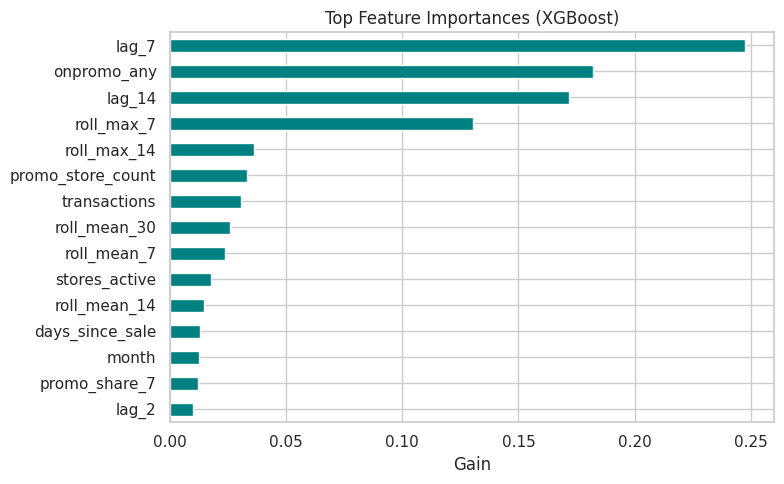

In [16]:
# Get feature importances as a sorted Series
xgb_feature_importance = pd.Series(
    xgb_model.feature_importances_, 
    index=feature_cols
).sort_values(ascending=False)

# Plot top 15 features
plt.figure(figsize=(8, 5))
xgb_feature_importance.head(15)[::-1].plot(kind='barh', color='teal')
plt.title('Top Feature Importances (XGBoost)')
plt.xlabel('Gain')
plt.tight_layout()
plt.show()

### 6.4: CatBoost

In [17]:
# CatBoost training
cat_model = CatBoostRegressor(
    depth=8,
    learning_rate=0.05,
    iterations=1500,
    loss_function='MAE',
    random_state=42,
    verbose=False
)
cat_model.fit(X_train, y_train)

cat_preds = cat_model.predict(X_test)

cat_precision, cat_recall = spike_precision_recall(
    y_test.values,
    cat_preds,
    threshold=3 * max(1.0, y_train.mean())
)

cat_metrics = {
    'MASE': mase(y_test.values, cat_preds, y_train.values),
    'wMAPE': wmape(y_test.values, cat_preds),
    'SpikePrecision': cat_precision,
    'SpikeRecall': cat_recall,
}

print("CatBoost metrics:", cat_metrics)

testdf = testdf.assign(catboost_pred=cat_preds)

cat_forecasts = {
    item_id: group.sort_values('report_date')['catboost_pred'].values
    for item_id, group in testdf.groupby('item_nbr')
}


CatBoost metrics: {'MASE': 3.4669333654563435, 'wMAPE': 0.9920374205067487, 'SpikePrecision': 0.5326530612244897, 'SpikeRecall': 0.9595588235294118}


### 6.5: CNN-LSTM

In [18]:
SEQ_FEATURES = ['unit_sales', 'onpromo_any', 'promo_share_7', 'promo_share_30', 'oil_price', 'transactions']

X_seq = []
y_seq = []
sequence_index = []

for item_id, item_df in panel.groupby('item_nbr', sort=False):
    item_df = item_df.reset_index(drop=True)
    values = item_df[SEQ_FEATURES].values.astype('float32')
    target = item_df['unit_sales'].values.astype('float32')
    train_len = len(item_df) - HOLDOUT_DAYS
    for idx in range(LOOKBACK, train_len):
        X_seq.append(values[idx-LOOKBACK:idx])
        y_seq.append(target[idx])
        sequence_index.append(item_id)

X_seq = np.array(X_seq, dtype='float32')
y_seq = np.array(y_seq, dtype='float32')

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(LOOKBACK, len(SEQ_FEATURES))),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mae')

history = model.fit(
    X_seq,
    y_seq,
    epochs=20,
    batch_size=256,
    validation_split=0.1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)],
    verbose=2
)


2025-11-21 17:18:24.485760: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
20/20 - 3s - 146ms/step - loss: 26.2147 - val_loss: 10.8548
Epoch 2/20
20/20 - 1s - 26ms/step - loss: 26.0925 - val_loss: 10.9241
Epoch 3/20
20/20 - 0s - 25ms/step - loss: 26.0189 - val_loss: 10.8944
Epoch 4/20
20/20 - 1s - 27ms/step - loss: 25.9598 - val_loss: 10.8635


In [19]:
def forecast_lstm(item_df: pd.DataFrame) -> np.ndarray:
    item_df = item_df.reset_index(drop=True)
    values = item_df[SEQ_FEATURES].values.astype('float32')
    buffer = values[:len(item_df) - HOLDOUT_DAYS].tolist()
    holdout_values = values[len(item_df) - HOLDOUT_DAYS:]
    preds = []
    for step in range(HOLDOUT_DAYS):
        seq_input = np.array(buffer[-LOOKBACK:], dtype='float32')[None, ...]
        pred = model.predict(seq_input, verbose=0)[0, 0]
        new_row = holdout_values[step].copy()
        new_row[0] = pred
        buffer.append(new_row)
        preds.append(pred)
    return np.array(preds, dtype='float32')

nn_results = []
nn_forecasts = {}

for item_id, item_df in panel.groupby('item_nbr', sort=False):
    train_df = item_df.iloc[:-HOLDOUT_DAYS]
    test_df = item_df.iloc[-HOLDOUT_DAYS:]
    preds = forecast_lstm(item_df)
    nn_forecasts[item_id] = preds

    precision, recall = spike_precision_recall(
        test_df['unit_sales'].values,
        preds,
        threshold=3 * max(1.0, train_df['unit_sales'].mean()),
    )

    nn_results.append({
        'item_nbr': item_id,
        'model': 'cnn_lstm',
        'MASE': mase(test_df['unit_sales'].values, preds, train_df['unit_sales'].values),
        'wMAPE': wmape(test_df['unit_sales'].values, preds),
        'SpikePrecision': precision,
        'SpikeRecall': recall,
    })

nn_results = pd.DataFrame(nn_results)
# Cell: CNN-LSTM summary
nn_summary = nn_results.groupby('model')[['MASE', 'wMAPE', 'SpikePrecision', 'SpikeRecall']].mean()
display(nn_summary)


,MASE,wMAPE,SpikePrecision,SpikeRecall
model,,,,
cnn_lstm,2.483,1.000,NaN,0.000


In [20]:
# Only kept models that delivered complete 60-day holdout forecasts
prediction_sources = {
    'sba': baseline_forecasts['sba'],
    'tsb': baseline_forecasts['tsb'],
    'xgboost': xgb_forecasts,
    'catboost': cat_forecasts,
    'cnn_lstm': nn_forecasts,
}

model_item_map = {}
for model_name, preds in prediction_sources.items():
    valid_items = {
        item_id
        for item_id, values in preds.items()
        if values is not None and len(np.asarray(values)) == HOLDOUT_DAYS
    }
    model_item_map[model_name] = valid_items
    print(f"{model_name}: {len(valid_items)} items with complete forecasts")

common_items = set(actual_holdout.keys())
for items in model_item_map.values():
    common_items &= items
common_items = sorted(common_items)
if not common_items:
    raise ValueError("No SKU has complete forecasts from the remaining models.")

print("Items used for tests:", len(common_items))

for model_name, preds in prediction_sources.items():
    for item_id in common_items:
        preds[item_id] = np.asarray(preds[item_id], dtype=float)

print("Sample lengths:", {m: prediction_sources[m][common_items[0]].shape[0] for m in prediction_sources})

sba: 20 items with complete forecasts
tsb: 20 items with complete forecasts
xgboost: 20 items with complete forecasts
catboost: 20 items with complete forecasts
cnn_lstm: 20 items with complete forecasts
Items used for tests: 20
Sample lengths: {'sba': 60, 'tsb': 60, 'xgboost': 60, 'catboost': 60, 'cnn_lstm': 60}


# MODEL COMPARISON

In [21]:
# Check structure of results dataframes
print("Baseline results columns:", baseline_results.columns.tolist())
print("NN results columns:", nn_results.columns.tolist())
print("\nSample baseline_results:")
display(baseline_results.head())


Baseline results columns: ['item_nbr', 'model', 'MASE', 'wMAPE', 'SpikePrecision', 'SpikeRecall']
NN results columns: ['item_nbr', 'model', 'MASE', 'wMAPE', 'SpikePrecision', 'SpikeRecall']

Sample baseline_results:


,item_nbr,model,MASE,wMAPE,SpikePrecision,SpikeRecall
0,2122188,naive,NaN,1.000,NaN,0.000
1,2122188,seasonal_naive,NaN,1.000,NaN,0.000
2,2122188,ses,NaN,1.000,NaN,0.000
3,2122188,croston,NaN,1.000,NaN,0.000
4,2122188,sba,NaN,1.000,NaN,0.000


In [22]:
# Consolidate all predictions
prediction_sources = {
    'sba': baseline_forecasts['sba'],
    'tsb': baseline_forecasts['tsb'],
    'xgboost': xgb_forecasts,
    'catboost': cat_forecasts,
    'cnn_lstm': nn_forecasts,
}

print("Models in prediction_sources:", list(prediction_sources.keys()))
print("Sample item counts:", {model: len(forecasts) for model, forecasts in prediction_sources.items()})

Models in prediction_sources: ['sba', 'tsb', 'xgboost', 'catboost', 'cnn_lstm']
Sample item counts: {'sba': 20, 'tsb': 20, 'xgboost': 20, 'catboost': 20, 'cnn_lstm': 20}


In [23]:
# Overall model comparison
comparison = pd.concat(
    [
        baseline_summary,
        sarimax_summary,
        pd.DataFrame([xgb_metrics], index=['xgboost']),
        pd.DataFrame([cat_metrics], index=['catboost']),
        nn_summary
    ],
    axis=0,
    sort=False
)
display(comparison)


,MASE,wMAPE,SpikePrecision,SpikeRecall
seasonal_naive,2.443,0.946,0.875,0.071
ses,2.527,1.073,NaN,0.000
tsb,2.549,1.105,NaN,0.000
naive,2.812,1.500,0.117,0.071
sba,"24,615.606",535.358,0.077,0.143
croston,"25,911.294",563.498,0.077,0.143
sarimax,NaN,NaN,NaN,NaN
xgboost,8.415,2.408,0.490,1.000
catboost,3.467,0.992,0.533,0.960
cnn_lstm,2.483,1.000,NaN,0.000


# STATISTICAL TESTS

In [24]:
# Diebold-Mariano Test Function
def diebold_mariano_test(errors_a, errors_b, h=1):
    """
    Diebold-Mariano test for comparing forecast accuracy.
    
    H0: both models have equal predictive accuracy
    H1: Model A is more accurate than Model B
    
    Returns (DM_statistic, p_value)
    """
    d = errors_a - errors_b
    mean_d = np.mean(d)
    n = len(d)
    
    # Autocorrelation-adjusted variance
    gamma_0 = np.var(d, ddof=1)
    gamma_sum = 0
    for k in range(1, h):
        if k < n:
            gamma_k = np.cov(d[:-k], d[k:])[0, 1]
            gamma_sum += gamma_k
    
    variance = (gamma_0 + 2 * gamma_sum) / n
    
    if variance <= 0:
        return np.nan, np.nan
    
    dm_stat = mean_d / np.sqrt(variance)
    p_value = 2 * (1 - t.cdf(np.abs(dm_stat), df=n-1))
    
    return dm_stat, p_value

In [25]:
actual_holdout = {}
for item_id in common_items:
    mask = (panel['item_nbr'] == item_id)
    item_series = panel.loc[mask, 'unit_sales'].values
    actual_holdout[item_id] = item_series[-HOLDOUT_DAYS:]

In [26]:
# Run pairwise Diebold-Mariano tests
available_models = list(prediction_sources.keys())
dm_results = []

for i, model_a in enumerate(available_models):
    for model_b in available_models[i+1:]:
        errors_a_all = []
        errors_b_all = []
        
        for item_id in common_items:
            actual = actual_holdout[item_id]
            pred_a = prediction_sources[model_a][item_id]
            pred_b = prediction_sources[model_b][item_id]
            
            errors_a_all.extend(np.abs(actual - pred_a))
            errors_b_all.extend(np.abs(actual - pred_b))
        
        errors_a_all = np.array(errors_a_all)
        errors_b_all = np.array(errors_b_all)
        
        dm_stat, p_val = diebold_mariano_test(errors_a_all, errors_b_all)
        
        dm_results.append({
            'Model A': model_a,
            'Model B': model_b,
            'DM statistic': dm_stat,
            'p-value': p_val
        })

dm_df = pd.DataFrame(dm_results)
display(dm_df)

,Model A,Model B,DM statistic,p-value
0,sba,tsb,12.720,0.000
1,sba,xgboost,12.673,0.000
2,sba,catboost,12.726,0.000
3,sba,cnn_lstm,12.726,0.000
4,tsb,xgboost,-12.286,0.000
5,tsb,catboost,3.228,0.001
6,tsb,cnn_lstm,6.024,0.000
7,xgboost,catboost,17.883,0.000
8,xgboost,cnn_lstm,13.948,0.000
9,catboost,cnn_lstm,-0.165,0.869


In [27]:
# Friedman Test
print("Friedman Test for multiple model comparison:")
print("H0: All models have equal predictive accuracy")
print()

# Prepare error matrix (items × models)
error_matrix = []
for item_id in common_items:
    item_errors = []
    actual = actual_holdout[item_id]
    
    for model_name in available_models:
        pred = prediction_sources[model_name][item_id]
        mae = np.mean(np.abs(actual - pred))
        item_errors.append(mae)
    
    error_matrix.append(item_errors)

error_matrix = np.array(error_matrix)

# Run Friedman test
statistic, p_value = friedmanchisquare(*error_matrix.T)

print(f"Friedman statistic: {statistic:.4f}")
print(f"p-value: {p_value:.6f}")

if p_value < 0.05:
    print("Result: Reject H0 - Models have significantly different accuracies")
else:
    print("Result: Fail to reject H0 - No significant difference between models")

Friedman Test for multiple model comparison:
H0: All models have equal predictive accuracy

Friedman statistic: 27.3646
p-value: 0.000017
Result: Reject H0 - Models have significantly different accuracies


In [28]:
# Average ranks (post-hoc for Friedman)
avg_ranks = rankdata(error_matrix, axis=1).mean(axis=0)
rank_df = pd.DataFrame({
    'Model': available_models,
    'Average Rank': avg_ranks
}).sort_values('Average Rank')

print("\nAverage ranks (lower is better):")
display(rank_df)


Average ranks (lower is better):


,Model,Average Rank
4,cnn_lstm,2.175
1,tsb,2.350
3,catboost,2.600
0,sba,3.575
2,xgboost,4.300


In [29]:
# Critical difference plot data (visualization prep)
print("\nRank differences:")
for i, model_a in enumerate(available_models):
    for j, model_b in enumerate(available_models):
        if i < j:
            rank_diff = abs(avg_ranks[i] - avg_ranks[j])
            print(f"{model_a} vs {model_b}: {rank_diff:.3f}")


Rank differences:
sba vs tsb: 1.225
sba vs xgboost: 0.725
sba vs catboost: 0.975
sba vs cnn_lstm: 1.400
tsb vs xgboost: 1.950
tsb vs catboost: 0.250
tsb vs cnn_lstm: 0.175
xgboost vs catboost: 1.700
xgboost vs cnn_lstm: 2.125
catboost vs cnn_lstm: 0.425


# VISUALIZATION

In [30]:
# Helper functions for plots
holdout_panel = panel_ml.loc[~train_mask, ['item_nbr', 'report_date', 'unit_sales']].copy()
holdout_panel['report_date'] = pd.to_datetime(holdout_panel['report_date'])
actual_daily = holdout_panel.groupby('report_date')['unit_sales'].sum().sort_index()

def aggregate_forecasts(forecast_dict):
    frames = []
    for item_id, preds in forecast_dict.items():
        dates = (
            holdout_panel.loc[holdout_panel['item_nbr'] == item_id]
            .sort_values('report_date')['report_date']
            .values
        )
        if len(preds) == len(dates):
            frames.append(pd.DataFrame({'report_date': dates, 'pred': preds}))
    if not frames:
        return None
    agg = pd.concat(frames).groupby('report_date')['pred'].sum().sort_index()
    return agg

def plot_series(name, series, row_axes):
    ts_ax, sc_ax = row_axes
    ts_ax.plot(actual_daily.index, actual_daily.values, label='Actual', color='black', linewidth=2)
    ts_ax.plot(series.index, series.values, label=name, linestyle='--')
    ts_ax.set_title(f'{name}: Holdout Daily Totals')
    ts_ax.set_xlabel('Date')
    ts_ax.set_ylabel('Units')
    ts_ax.legend()
    ts_ax.tick_params(axis='x', rotation=45)
    
    aligned_preds = series.reindex(actual_daily.index).values
    sc_ax.scatter(actual_daily.values, aligned_preds, alpha=0.6)
    max_val = max(actual_daily.max(), series.max())
    sc_ax.plot([0, max_val], [0, max_val], '--', color='gray')
    sc_ax.set_title(f'{name}: Actual vs Predicted')
    sc_ax.set_xlabel('Actual units')
    sc_ax.set_ylabel('Predicted units')


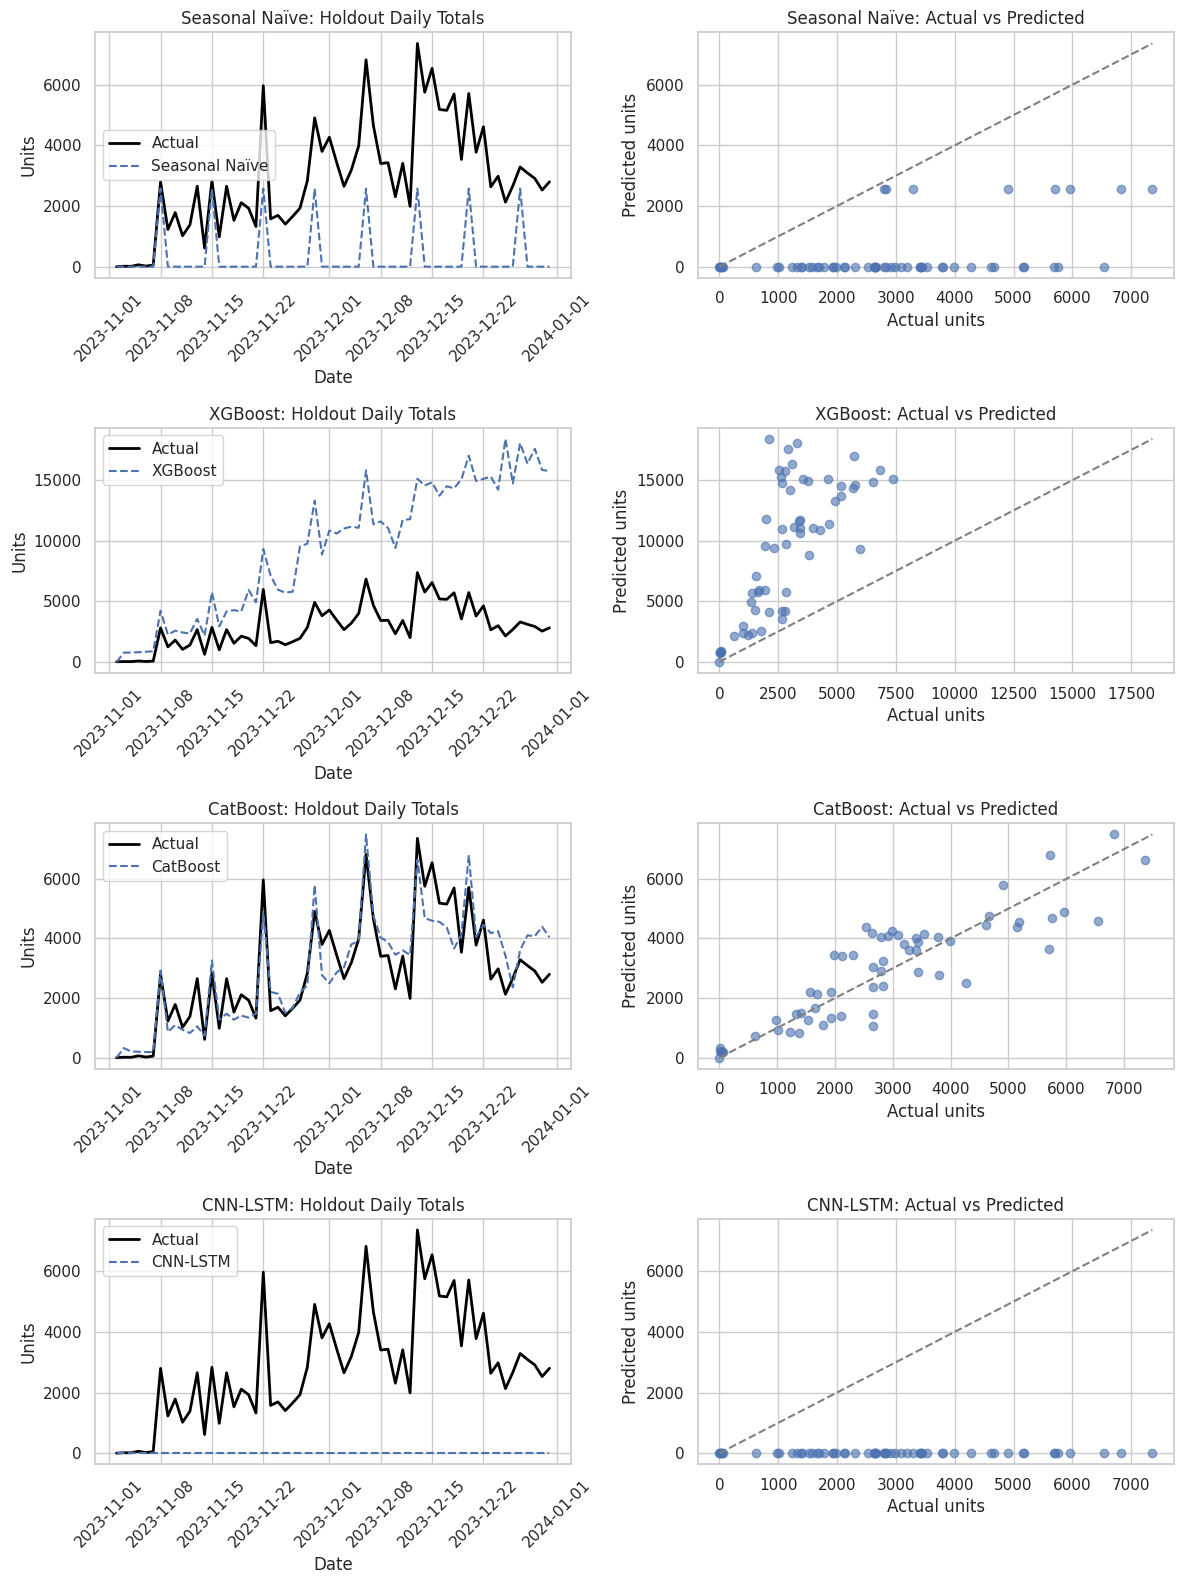

In [31]:
# Generate plots for all models
model_plots = []
if 'seasonal_naive' in baseline_forecasts:
    model_plots.append(('Seasonal Naïve', aggregate_forecasts(baseline_forecasts['seasonal_naive'])))
if 'xgboost' in prediction_sources:
    model_plots.append(('XGBoost', aggregate_forecasts(prediction_sources['xgboost'])))
if 'catboost' in prediction_sources:
    model_plots.append(('CatBoost', aggregate_forecasts(prediction_sources['catboost'])))
if 'cnn_lstm' in prediction_sources:
    model_plots.append(('CNN-LSTM', aggregate_forecasts(prediction_sources['cnn_lstm'])))

fig, axes = plt.subplots(len(model_plots), 2, figsize=(12, 4 * len(model_plots)))
if len(model_plots) == 1:
    axes = np.array([axes])
for (name, series), row_axes in zip(model_plots, axes):
    if series is not None:
        plot_series(name, series, row_axes)
plt.tight_layout()
plt.show()

# RESIDUAL DIAGNOSTICS

In [32]:
# Compute residuals and run Ljung-Box test
print("Ljung-Box Test for Residual Autocorrelation")
print("H0: Residuals are independently distributed (no autocorrelation)\n")
print("=" * 70)

lb_results = []

for model_name in prediction_sources.keys():
    all_residuals = []
    
    for item_id in common_items:
        actual = actual_holdout[item_id]
        pred = prediction_sources[model_name][item_id]
        residual = actual - pred
        all_residuals.extend(residual)
    
    residuals = np.array(all_residuals)
    
    # Ljung-Box test
    lb_test = acorr_ljungbox(residuals, lags=10, return_df=True)
    significant = (lb_test['lb_pvalue'] < 0.05).any()
    min_pvalue = lb_test['lb_pvalue'].min()
    
    lb_results.append({
        'Model': model_name,
        'Min p-value': min_pvalue,
        'Autocorrelation': 'Yes' if significant else 'No'
    })
    
    print(f"{model_name.upper()}:")
    print(f"  Min p-value (across lags 1-10): {min_pvalue:.6f}")
    print(f"  Autocorrelation detected: {'Yes' if significant else 'No'}")
    print()

print("=" * 70)
lb_df = pd.DataFrame(lb_results)
display(lb_df)

Ljung-Box Test for Residual Autocorrelation
H0: Residuals are independently distributed (no autocorrelation)

SBA:
  Min p-value (across lags 1-10): 0.000000
  Autocorrelation detected: Yes

TSB:
  Min p-value (across lags 1-10): 0.000000
  Autocorrelation detected: Yes

XGBOOST:
  Min p-value (across lags 1-10): 0.000000
  Autocorrelation detected: Yes

CATBOOST:
  Min p-value (across lags 1-10): 0.000000
  Autocorrelation detected: Yes

CNN_LSTM:
  Min p-value (across lags 1-10): 0.000000
  Autocorrelation detected: Yes



,Model,Min p-value,Autocorrelation
0,sba,0.000,Yes
1,tsb,0.000,Yes
2,xgboost,0.000,Yes
3,catboost,0.000,Yes
4,cnn_lstm,0.000,Yes


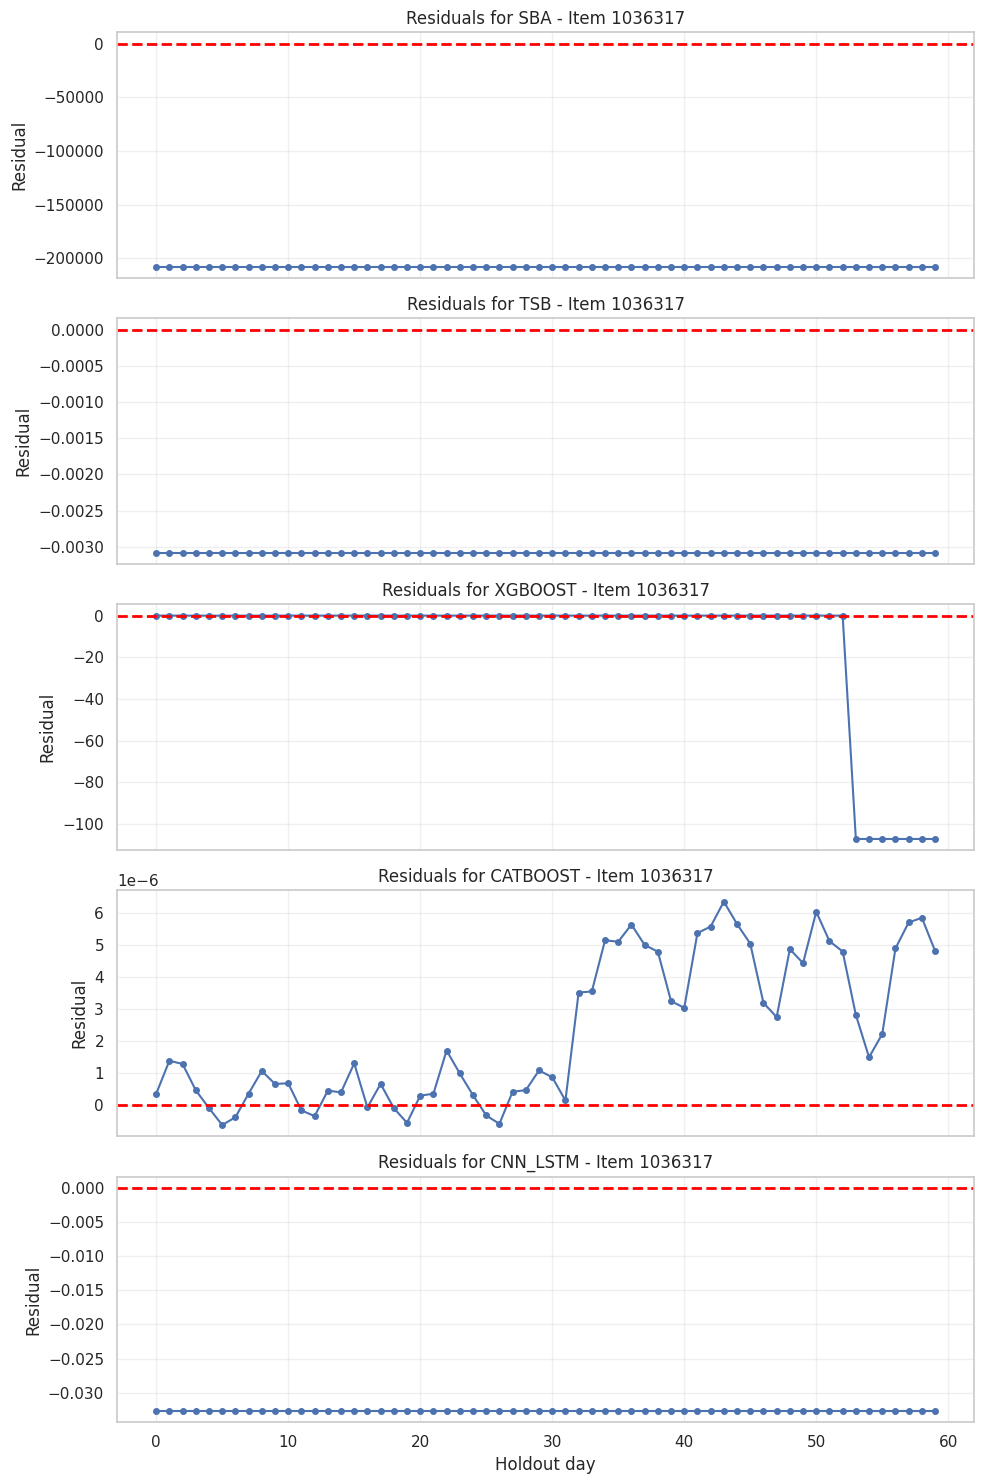

In [33]:
# Single residual plot for one sample item
sample_item = common_items[0]

fig, axes = plt.subplots(len(prediction_sources), 1, figsize=(10, 3 * len(prediction_sources)), sharex=True)
if len(prediction_sources) == 1:
    axes = [axes]

for idx, model_name in enumerate(prediction_sources.keys()):
    actual = actual_holdout[sample_item]
    pred = prediction_sources[model_name][sample_item]
    residuals = actual - pred
    
    ax = axes[idx]
    ax.plot(range(len(residuals)), residuals, marker='o', markersize=4, linestyle='-', linewidth=1.5)
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_title(f'Residuals for {model_name.upper()} - Item {sample_item}')
    ax.set_ylabel('Residual')
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Holdout day')
plt.tight_layout()
plt.show()

# PER-ITEM ANALYSIS

In [34]:
# Per-item metrics
per_item_records = []
common_items = list(prediction_sources['sba'].keys())

for model_name in prediction_sources.keys():
    if model_name in ['sba', 'tsb']:
        df = baseline_results[baseline_results['model'] == model_name].copy()
    elif model_name == 'xgboost':
        rows = []
        for item_id in common_items:
            actual = actual_holdout[item_id]
            preds = prediction_sources['xgboost'][item_id]
            train = panel[panel['item_nbr'] == item_id]['unit_sales'].iloc[:-HOLDOUT_DAYS].values
            precision, recall = spike_precision_recall(
                actual, preds, threshold=3 * max(1.0, train.mean())
            )
            rows.append({
                'item_nbr': item_id,
                'model': 'xgboost',
                'MASE': mase(actual, preds, train),
                'wMAPE': wmape(actual, preds),
                'SpikePrecision': precision,
                'SpikeRecall': recall,
            })
        df = pd.DataFrame(rows)
    elif model_name == 'catboost':
        rows = []
        for item_id in common_items:
            actual = actual_holdout[item_id]
            preds = prediction_sources['catboost'][item_id]
            train = panel[panel['item_nbr'] == item_id]['unit_sales'].iloc[:-HOLDOUT_DAYS].values
            precision, recall = spike_precision_recall(
                actual, preds, threshold=3 * max(1.0, train.mean())
            )
            rows.append({
                'item_nbr': item_id,
                'model': 'catboost',
                'MASE': mase(actual, preds, train),
                'wMAPE': wmape(actual, preds),
                'SpikePrecision': precision,
                'SpikeRecall': recall,
            })
        df = pd.DataFrame(rows)
    else:  # cnn_lstm
        df = nn_results[nn_results['model'] == model_name].copy()
    
    per_item_records.append(df[['item_nbr', 'model', 'MASE', 'wMAPE', 'SpikePrecision', 'SpikeRecall']])

per_item_metrics = pd.concat(per_item_records, ignore_index=True)
display(per_item_metrics.head(20))


,item_nbr,model,MASE,wMAPE,SpikePrecision,SpikeRecall
0,2122188,sba,NaN,1.000,NaN,0.000
1,2118662,sba,NaN,1.000,NaN,0.000
2,2127114,sba,NaN,1.000,NaN,0.000
3,2124052,sba,"144,380.554","7,424.558",0.500,1.000
4,2037148,sba,"7,815.401",NaN,0.000,NaN
5,2008567,sba,"3,114.493",NaN,0.000,NaN
6,2113343,sba,NaN,1.000,NaN,0.000
7,2054300,sba,NaN,1.000,NaN,0.000
8,2114812,sba,NaN,1.000,NaN,0.000
9,2116416,sba,NaN,1.000,NaN,0.000
